### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### План выполнения
1. Изучить данные;
2. Подготовить данные;
3. Проанализировать данные;
4. Проверить гипотезы;
5. Сделать вывод.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import stats as st
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(palette=sns.color_palette())
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# Загрузим данные
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

### 1. Изучим данные

#### Calls

In [5]:
def print_df_info(df):
    display(df.sample())
    print()
    display(df.info())
    print()
    display(df.describe().T)
    print()
    print('Количество дубликатов:', df.duplicated().sum())
    
# Таблица calls содержит информацию о звонках
print_df_info(df_calls)

,id,call_date,duration,user_id
98119,1250_39,2018-04-19,22.68,1250



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
duration,202607.00,6.76,5.84,0.00,1.30,6.00,10.70,38.00
user_id,202607.00,1253.94,144.72,1000.00,1126.00,1260.00,1379.00,1499.00



Количество дубликатов: 0


- id — уникальный номер звонка;
- call_date — дата звонка;
- duration — длительность звонка в минутах;
- user_id — идентификатор пользователя, сделавшего звонок.

Дубликатов нет, явных пропусков нет, есть звонки с нулевой длительностью.

Столбец `call_date` нужно привести к типу datetime.

#### Internet

In [6]:
# Таблица internet содержит информацию об интернет-сессиях
print_df_info(df_internet)

,id,mb_used,session_date,user_id
86541,1292_657,931.13,2018-07-14,1292



<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

,count,mean,std,min,25%,50%,75%,max
mb_used,149396.00,370.19,278.30,0.00,138.19,348.01,559.55,1724.83
user_id,149396.00,1252.10,144.05,1000.00,1130.00,1251.00,1380.00,1499.00



Количество дубликатов: 0


- id — уникальный номер сессии;
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
- session_date — дата интернет-сессии;
- user_id — идентификатор пользователя.

Дубликатов нет, явных пропусков нет, eсть записи с нулем потраченных мегабайтов.

Столбец `session_date` нужно привести к типу datetime.

#### Messages

In [7]:
# Таблица messages содержит информацию о сообщениях
print_df_info(df_messages)

,id,message_date,user_id
108791,1437_33,2018-12-31,1437



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
user_id,123036.00,1256.99,143.52,1000.00,1134.00,1271.00,1381.00,1499.00



Количество дубликатов: 0


- id — уникальный номер сообщения;
- message_date — дата сообщения;
- user_id — идентификатор пользователя, отправившего сообщение;

Дубликатов нет, столбец `message_date` нужно привести к типу datetime.

#### Tariffs

In [8]:
# Таблица tariffs содержит информацию о текущих тарифах
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


- tariff_name — название тарифа;
- rub_monthly_fee — ежемесячная абонентская плата в рублях;
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
- messages_included — количество сообщений в месяц, включённых в абонентскую плату;
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

#### Users

In [9]:
# Таблица users содержит информацию о пользователях
print_df_info(df_users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
200,1200,36,NaN,Санкт-Петербург,Тамара,Ларионова,2018-04-28,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
user_id,500.00,1249.50,144.48,1000.00,1124.75,1249.50,1374.25,1499.00
age,500.00,46.59,16.67,18.00,32.00,46.00,62.00,75.00



Количество дубликатов: 0


- user_id — уникальный идентификатор пользователя;
- first_name — имя пользователя;
- last_name — фамилия пользователя;
- age — возраст пользователя (годы);
- reg_date — дата подключения тарифа (день, месяц, год);
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- city — город проживания пользователя;
- tariff — название тарифного плана.

In [10]:
df_users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Дубликатов нет, явные пропуски в колонке `churn_date`. Отношение разных тарифов 70/30.

Колонки `churn_date`, `reg_date` нужно привести к типу datetime, колонки `tariff` и `city` к типу category.

In [11]:
print(f'Количество пользователей, по которым есть данные:')
for df, name in [(df_messages, 'Сообщения'), (df_calls, 'Минуты'), (df_internet, 'Интернет')]:
    print(name+':', df.user_id.unique().shape[0])

Количество пользователей, по которым есть данные:
Сообщения: 426
Минуты: 492
Интернет: 497


### 2. Подготовим данные

Приведем данные к нужным типам

In [12]:
df_calls.call_date = pd.to_datetime(df_calls.call_date, format='%Y-%m-%d')
df_internet.session_date = pd.to_datetime(df_internet.session_date, format='%Y-%m-%d')
df_messages.message_date = pd.to_datetime(df_messages.message_date, format='%Y-%m-%d')
df_users.churn_date = pd.to_datetime(df_users.churn_date, format='%Y-%m-%d')
df_users.reg_date = pd.to_datetime(df_users.reg_date, format='%Y-%m-%d')
df_users.tariff = df_users.tariff.astype('category')
df_users.city = df_users.city.astype('category')

Мы обнаружили две проблемы в данных: звонки с нулем минут (возможно, пропущенные звонки) и выход в интернет с нулем мегабайт, оценим их количество.

In [13]:
print(f'Доля звонков длительностью 0 минут: {(df_calls.duration==0).sum()/df_calls.shape[0]:.2%}')
print(f'Доля выходов в интернет с трафиком 0 МБ: {(df_internet.mb_used==0).sum()/df_internet.shape[0]:.2%}')

Доля звонков длительностью 0 минут: 19.55%
Доля выходов в интернет с трафиком 0 МБ: 13.12%


Удалим эти записи, так как на оценку прибыли в нашем случае они не влияют.

In [14]:
df_internet = df_internet[~(df_internet.mb_used==0)]
df_calls = df_calls[~(df_calls.duration==0)]

Округлим минуты большую сторону

In [15]:
df_calls['ceiled_duration'] = np.ceil(df_calls['duration']).astype('int')

Выделим месяц, в который совершили звонок, написали смс или пользовались интернетом

In [16]:
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

Посчитаем сколько дней абоненты пользуются связью

In [17]:
df_users['days_of_using'] = df_users.churn_date - df_users.reg_date

In [18]:
# Клиенты, пользовавшиеся тарифом меньше месяца
df_users[df_users['days_of_using'].dt.days<30]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,days_of_using
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart,23 days
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,8 days
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,5 days


Три человека пользовались тарифом меньше месяца, их можно удалить

In [19]:
df_users.drop(df_users[df_users['days_of_using'].dt.days<30].index, inplace=True)

Посчитаем минуты, смс и трафик по месяцам для каждого клиента.

In [20]:
calls_grouped = df_calls.groupby(['user_id', 'month'])['ceiled_duration'].sum().reset_index()
calls_grouped.columns = ['user_id', 'month','minutes']

messages_grouped = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_grouped.columns = ['user_id', 'month','messages']

internet_grouped = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_grouped.columns = ['user_id', 'month','mb_used']
internet_grouped['GB_used'] = np.ceil(internet_grouped['mb_used']/1024).astype('int')

Создадим новую таблицу

In [21]:
# Объеденим предыдущие таблицы по id клиента и месяцу
df = calls_grouped.merge(messages_grouped, how='outer', on=['user_id', 'month'])
df = df.merge(internet_grouped, how='outer', on=['user_id', 'month'])

# Заполним пропуски 0
df.fillna(0, inplace=True)

#Дополним таблицу информацией о тарифе, чтобы удобнее было высчитывать доход
df = df.merge(df_users[['user_id', 'tariff', 'city']], how='inner',  on=['user_id'])
df = df.merge(df_tariffs, how='inner',  left_on=['tariff'], right_on=['tariff_name'])

df[['minutes', 'messages', 'GB_used', 'mb_used']] = df[['minutes', 'messages', 'GB_used', 'mb_used']].astype('int')
df

,user_id,month,minutes,messages,mb_used,GB_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159,22,2253,3,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,172,60,23233,23,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,340,75,14003,14,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,408,81,14055,14,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,466,57,14568,15,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,1489,8,0,17,11050,11,smart,Санкт-Петербург,50,15360,500,550,200,3,3,smart
3208,1489,9,0,32,17206,17,smart,Санкт-Петербург,50,15360,500,550,200,3,3,smart
3209,1489,10,0,21,19559,20,smart,Санкт-Петербург,50,15360,500,550,200,3,3,smart
3210,1489,11,0,20,17491,18,smart,Санкт-Петербург,50,15360,500,550,200,3,3,smart


Посчитаем выручку

Посчитаем для каждого пользователя следующие данные:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [22]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [23]:
# ПЛата за тариф
df['tariff_cost'] = df['rub_monthly_fee']
df['revenue'] = df['rub_monthly_fee']

df['revenue_minutes'] = 0
df['revenue_messages'] = 0
df['revenue_internet'] = 0


# Считаем платы за дополнительные минуты, смс и интернет-трафик
df.loc[df['minutes']>df['minutes_included'], 'revenue_minutes'] += (df['minutes'] - df['minutes_included']) * df['rub_per_minute']
df.loc[df['mb_used']>df['mb_per_month_included'], 'revenue_internet'] += np.ceil((df['mb_used'] - df['mb_per_month_included'])/1024) * df['rub_per_gb']
df.loc[df['messages']>df['messages_included'], 'revenue_messages'] += (df['messages'] - df['messages_included']) * df['rub_per_message']

# Выручка = плата за тариф + плата за доп. минуты + плата за доп. смс + плата за доп.Гб
df['revenue'] += df['revenue_minutes'] + df['revenue_messages'] + df['revenue_internet']

# Приведем колонки к нужным типам и удалим лишние столбцы
df[['revenue', 'revenue_minutes', 'revenue_messages', 'revenue_internet']] = df[['revenue', 'revenue_minutes', 'revenue_messages', 'revenue_internet']].astype('int')
df.drop(df_tariffs.columns, axis=1, inplace=True)
df

,user_id,month,minutes,messages,mb_used,GB_used,tariff,city,tariff_cost,revenue,revenue_minutes,revenue_messages,revenue_internet
0,1000,5,159,22,2253,3,ultra,Краснодар,1950,1950,0,0,0
1,1000,6,172,60,23233,23,ultra,Краснодар,1950,1950,0,0,0
2,1000,7,340,75,14003,14,ultra,Краснодар,1950,1950,0,0,0
3,1000,8,408,81,14055,14,ultra,Краснодар,1950,1950,0,0,0
4,1000,9,466,57,14568,15,ultra,Краснодар,1950,1950,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,1489,8,0,17,11050,11,smart,Санкт-Петербург,550,550,0,0,0
3208,1489,9,0,32,17206,17,smart,Санкт-Петербург,550,950,0,0,400
3209,1489,10,0,21,19559,20,smart,Санкт-Петербург,550,1550,0,0,1000
3210,1489,11,0,20,17491,18,smart,Санкт-Петербург,550,1150,0,0,600


#### 3. Проанализируем данные

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [27]:
# Тариф 'smart'
describe = df.loc[df['tariff']=='smart',['minutes', 'messages', 'GB_used']].describe().T
describe['var'] = describe['std']**2
describe

,count,mean,std,min,25%,50%,75%,max,var
minutes,2227.00,418.00,190.38,0.00,282.00,422.00,545.00,1435.00,36244.43
messages,2227.00,33.40,28.23,0.00,10.00,28.00,51.00,143.00,797.15
GB_used,2227.00,16.34,5.74,0.00,13.00,17.00,20.00,38.00,32.96


In [28]:
# Тариф 'ultra'
describe = df.loc[df['tariff']=='ultra',['minutes', 'messages', 'GB_used']].describe().T
describe['var'] = describe['std']**2
describe

,count,mean,std,min,25%,50%,75%,max,var
minutes,985.00,526.62,317.61,0.00,284.00,518.00,752.00,1673.00,100873.63
messages,985.00,49.36,47.80,0.00,6.00,38.00,79.00,224.00,2285.27
GB_used,985.00,19.49,9.85,0.00,12.00,19.00,27.00,49.00,97.09


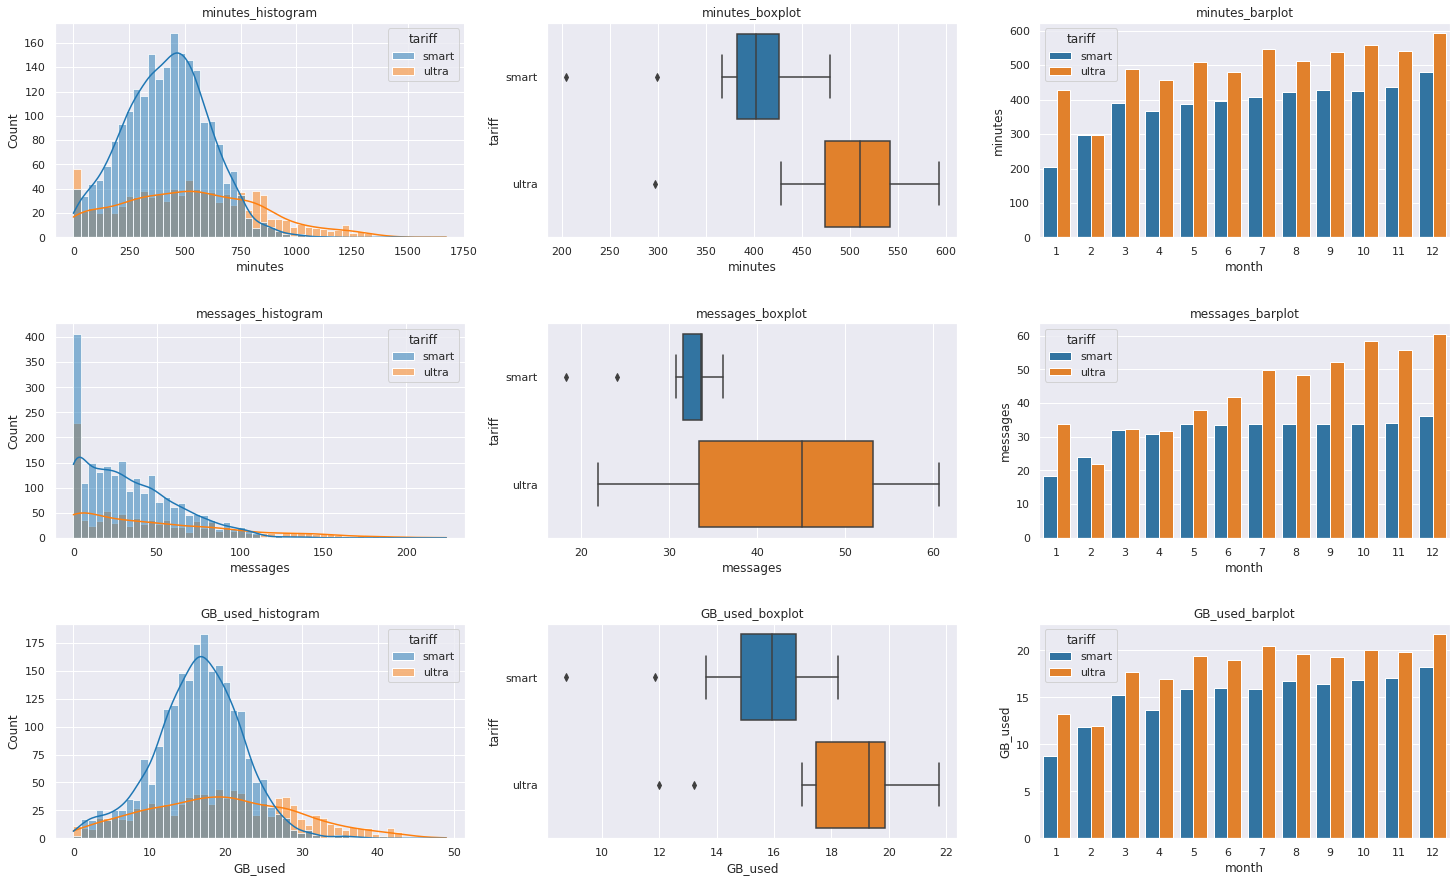

In [29]:
def hist_plotting(df, size=(25, 15), bins=50):

    cols_for_hist = ['minutes', 'messages', 'GB_used']
    fig, axs = plt.subplots(3,3, figsize=size)
    fig.subplots_adjust(hspace = 0.4, wspace=0.2)
    axs = axs.ravel()

    for i in range(0,9,3):
        
        col = cols_for_hist[i//3]
#         sns.histplot(data=df.pivot_table(index='tariff', columns='month', values=[col], aggfunc='mean').T, bins=bins, kde=True, ax=axs[i])
        sns.histplot(data=df.sort_values(by='tariff'), x=col, hue='tariff', bins=bins, kde=True, ax=axs[i])
        axs[i].set_title(col+'_histogram')
        axs[i].set_xlabel(col)

        sns.boxplot(x='value', y='tariff', data=pd.melt(df.pivot_table(index='tariff', columns='month', values=[col], aggfunc='mean').T), ax=axs[i+1])
        axs[i+1].set_title(col+'_boxplot')
        axs[i+1].set_xlabel(col)
        
        df_temp = pd.melt(df.pivot_table(index='tariff', columns='month', values=[col], aggfunc='mean').T).reset_index()
        df_temp['index']=df_temp['index']%12+1
        sns.barplot(x='index', y='value', hue='tariff', data=df_temp, ax=axs[i+2])
        axs[i+2].set_title(col+'_barplot')
        axs[i+2].set_xlabel('month')
        axs[i+2].set_ylabel(col)
        
        
hist_plotting(df)

Для тарифа «Смарт»:
- медианы длинны звонков - 418 минут, количества смс - 33, а интернет-трафика - 16 ГБ;
- в целом клиенты тратят меньше 480 минут, 35 смс и 19 ГБ;
- клиентам не всегда хватает выделенных лимитов по тарифу (500 минут, 50 смс, 15 ГБ);
- в течение года количество разговорных минут растет, как и количство потраченных мегабайт трафика;
- количество сообщений растет до середины года, а дальше практисески не изменяется.

Для тарифа «Ультра»:
- медианы длинны звонков - 526 минут, количества смс - 49, а интернет трафика - 19 ГБ;
- в целом клиенты тратят меньше 600 минут, 65 смс и 29 ГБ, за исключением редких случаев;
- почти все клиенты укладываются в лимиты по тарифу (3000 минут, 1000 смс, 30 ГБ);
- в течение года растет количество разговорных минут, потраченных мегабайт трафика и сообщейний.

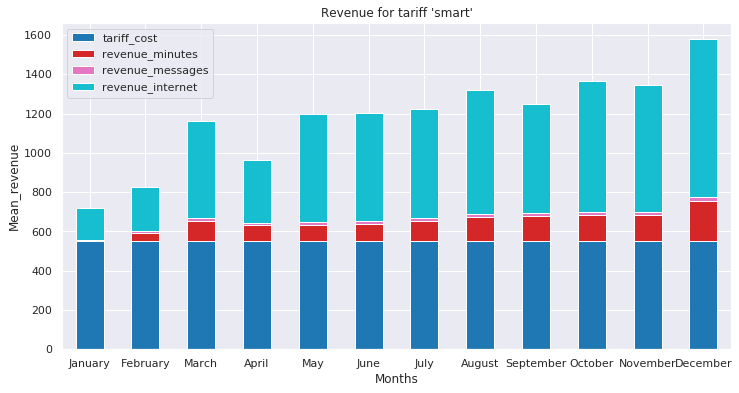

In [30]:
def monthly_revenue_plotting(df, tariff):
    
    month_name = ['January', 'February', 'March', 'April',
                  'May', 'June', 'July', 'August',
                  'September', 'October', 'November', 'December'
                 ]
    tariff_cost = df[df['tariff']==tariff].groupby('month')['tariff_cost'].mean().values
    revenue_minutes = df[df['tariff']==tariff].groupby('month')['revenue_minutes'].mean().values
    revenue_messages = df[df['tariff']==tariff].groupby('month')['revenue_messages'].mean().values
    revenue_internet = df[df['tariff']==tariff].groupby('month')['revenue_internet'].mean().values


    data = [month_name,tariff_cost, revenue_minutes, revenue_messages, revenue_internet]
    column_name_dict= {
        0:'Month',
        1:'tariff_cost',
        2:'revenue_minutes',
        3:'revenue_messages',
        4:'revenue_internet'
        }
    pd.DataFrame(data).T.rename(column_name_dict,axis=1).set_index('Month').plot(kind='bar',
                                                                                 stacked=True,
                                                                                 colormap=ListedColormap(sns.color_palette()),
                                                                                 figsize=(12,6)
                                                                                )
    plt.xticks(rotation=0)
    plt.title(f"Revenue for tariff '{tariff}'")
    plt.xlabel('Months')
    plt.ylabel('Mean_revenue')
    
monthly_revenue_plotting(df, 'smart')

Клиенты тарифа «Смарт» больше всего переплачивают за дополнительный интернет-трафик - в среднем до 800 рублей, немного переплачивают за минуты - до 200 рублей, и практически не переплачивают за смс.

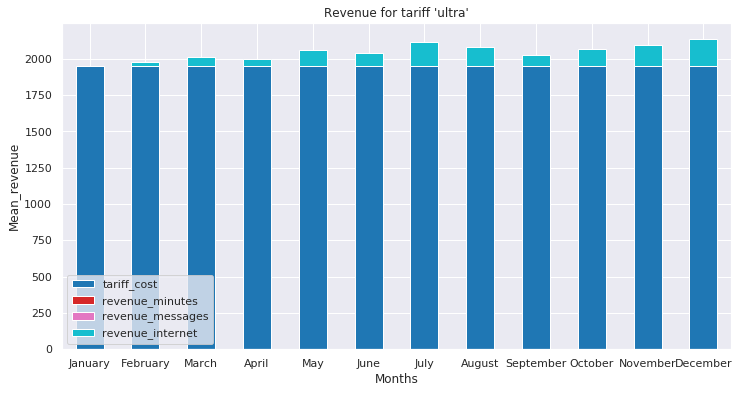

In [31]:
monthly_revenue_plotting(df,'ultra')

Клиенты тарифа «Ультра» переплачивают в основном только за интернет-трафик, около 300 рублей.

Посмотрим, сколько клиентов хоть раз переплачивали за телефонную связь.

In [32]:
a = df[df.tariff=='ultra'].groupby('user_id')['revenue'].mean()
print(f'Соотношение клиентов, хоть раз переплативших за тарифф «Ультра»: {a[a!=1950].shape[0]/ a.shape[0]:.2%}')

Соотношение клиентов, хоть раз переплативших за тарифф «Ультра»: 29.05%


In [33]:
a = df[df.tariff=='smart'].groupby('user_id')['revenue'].mean()
print(f'Соотношение клиентов, хоть раз переплативших за тарифф «Смарт»: {a[a!=550].shape[0]/ a.shape[0]:.2%}')

Соотношение клиентов, хоть раз переплативших за тарифф «Смарт»: 95.42%


### 4. Проверим гипотезы

1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

1. Сформулируем нулевую гипотезу $Н_0$: средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».


In [34]:
alpha = 0.05

sample1 = df.loc[df.tariff=='ultra','revenue'] 
sample2 = df.loc[df.tariff=='smart','revenue']

result = st.ttest_ind(sample1, sample2)

print(f'ultra: {sample1.mean():.5} руб.')
print(f'smart: {sample2.mean():.5} руб.')
print(f'pvalue: {result.pvalue:.4%}')

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

ultra: 2070.2 руб.
smart: 1290.6 руб.
pvalue: 0.0000%
Отвергаем нулевую гипотезу


Из-за преплат за интернет средняя выручка с клиента тарифа «Ультра» больше - 2070 рублей.

2. Сформулируем нулевую гипотезу $Н_0$: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

In [35]:
alpha = 0.05

sample1 = df.loc[df.city=='Москва','revenue'] 
sample2 = df.loc[~(df.city=='Москва'),'revenue']

result = st.ttest_ind(sample1, sample2)

print(f'Москва: {sample1.mean():.5} руб.')
print(f'Регионы: {sample2.mean():.5} руб.')
print(f'pvalue: {result.pvalue:.4%}' )

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Москва: 1550.0 руб.
Регионы: 1524.9 руб.
pvalue: 48.5715%
Не получилось отвергнуть нулевую гипотезу


Клиенты из Москвы в среднем платят за услуги мобильной связи столько же, сколько и клиенты из других регионов - 1550 рублей.

### 5. Вывод

После проведенного анализа можно сказать следующее:
- тариф «Ультра» дороже тарифа «Смарт» с учетом всех переплат - 2070 р. и 1290 р. соответственно;
- 95% клиентов с тарифом «Смарт» хоть раз перепплачивали за связь, у тарифа «Ультра» только 29% клиентов переплачивали за связь;
- клиентам тарифа «Ультра» практически полностью хватает выделенных лимитов, они доплачивают только за интернет (переплаты до 300 рублей);
- клиентам тарифа «Смарт» часто лимитов не хватает, они доплачивают в основном за интрнет, и, меньше, за звонки (в сумме переплаты до 1000 рублей);
- средняя выручка не зваисит от региона - в Москве она такая же как и везде, 1550  р. с клиента.

В целом у клиентов разных тарифов одинаковые потребности: много интернет-трафика, чуть меньше минут и совсем немного смс. Тариф «Ультра» лучше удовлетворяет эти потребности - они реже переплачивают. Тариф «Смарт» с учетом переплат выходит дешевле тарифа «Ультра».

Упор в рекламной кампании рекомендуется сделать на тариф «Ультра», он приносит больше прибыли с одного клиента.